# 1. Import packages and dataset

In [4]:
# Data processing and visualization packages
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.pipeline import Pipeline # Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder # Features engineering
from sklearn.compose import ColumnTransformer # Features engineering
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold # Dataset splitting and Cross-Validation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Evaluation metrics

# Models
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.ensemble import RandomForestRegressor # Random Forest
import xgboost as xgb # XGBoost
import lightgbm as lgb # LightGBM

In [5]:
# Import raw dataset
df = pd.read_csv('canada_us_electricity_trade.csv')

# Fitler only 'export' trade type
import_df = df[df['trade_type']=='import']

# Convert 'date' column to datetime data type
import_df['date'] = pd.to_datetime(import_df['date'], dayfirst=True)

import_df.head()

C:\Users\thanh\AppData\Local\Temp\ipykernel_2044\2011379919.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_df['date'] = pd.to_datetime(import_df['date'], dayfirst=True)


,utc,iso,ym,date,year,month,day,annual_hour,province,iso_info,...,geo_iso_share,gas_iso_share,other_iso_share,oil_iso_share,solar_iso_share,nuclear_iso_share,hydro_iso_share,wind_iso_share,solar_radiation,wind_speed
1,2018-01-01T04:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,5,NB,Maine,...,0.0,0.400581,0.000979,0.056172,0.005374,0.29426,0.076436,0.040998,0.0,4.822305
5,2018-01-01T05:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,6,NB,Maine,...,0.0,0.400581,0.000979,0.056172,0.005374,0.29426,0.076436,0.040998,0.0,4.956411
13,2018-01-01T06:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,7,NB,Maine,...,0.0,0.400581,0.000979,0.056172,0.005374,0.29426,0.076436,0.040998,0.0,5.031564
21,2018-01-01T07:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,8,NB,Maine,...,0.0,0.400581,0.000979,0.056172,0.005374,0.29426,0.076436,0.040998,0.0,5.023294
30,2018-01-01T08:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,9,NB,Maine,...,0.0,0.400581,0.000979,0.056172,0.005374,0.29426,0.076436,0.040998,0.0,4.893714


In [6]:
import_df.shape

(76249, 45)

# 2. Exploratory data analysis

## 2.1. Clean missing values

In [7]:
# Check missing value
null_check = import_df.isnull().sum()
null_check[null_check > 0]

iso_price    37
iso_load      9
henry_gas    26
aeco_gas     26
dtype: int64

### 2.1.1. iso_price

In [8]:
# Check characteristics of null rows
import_df[import_df['iso_price'].isnull()][['iso_info', 'iso_regulate', 'trade_type']]

,iso_info,iso_regulate,trade_type
22228,Montana,Partially Deregulated,import
22229,Northwest,Partially Deregulated,import
23984,Montana,Partially Deregulated,import
23985,Northwest,Partially Deregulated,import
32190,Northwest,Partially Deregulated,import
32200,Northwest,Partially Deregulated,import
32210,Northwest,Partially Deregulated,import
33920,Montana,Partially Deregulated,import
33921,Northwest,Partially Deregulated,import
33931,Montana,Partially Deregulated,import


iso_price mean: 38.56191423584736
iso_price median: 31.113753335


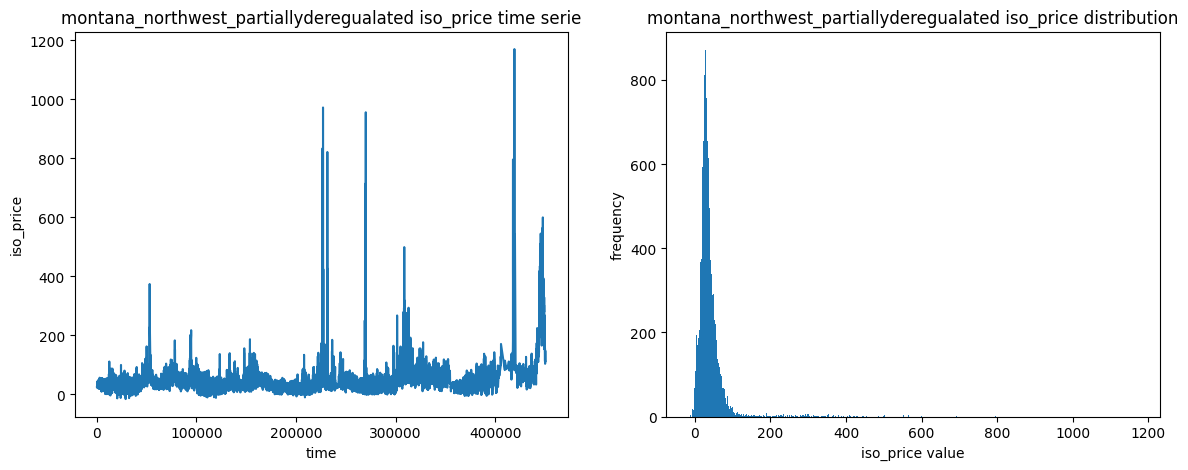

In [9]:
# Visualize to understand the non-null data pattern
iso_price_montana_northwest_partiallyderegulated_not_null = import_df[(import_df['iso_info']=='Montana') | (import_df['iso_info']=='Northwest') & import_df['iso_price'].notnull()]['iso_price']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(iso_price_montana_northwest_partiallyderegulated_not_null)
axes[0].set_title("montana_northwest_partiallyderegualated iso_price time serie")
axes[0].set_xlabel("time")
axes[0].set_ylabel("iso_price")

axes[1].hist(iso_price_montana_northwest_partiallyderegulated_not_null, bins = 2000)
axes[1].set_title("montana_northwest_partiallyderegualated iso_price distribution")
axes[1].set_xlabel("iso_price value")
axes[1].set_ylabel("frequency")

# Statistical measures
print(f'''iso_price mean: {iso_price_montana_northwest_partiallyderegulated_not_null.mean()}''')
print(f'''iso_price median: {iso_price_montana_northwest_partiallyderegulated_not_null.median()}''')

In [10]:
# Replace null values
import_df['iso_price'] = import_df['iso_price'].fillna(iso_price_montana_northwest_partiallyderegulated_not_null.median())

C:\Users\thanh\AppData\Local\Temp\ipykernel_2044\308108002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_df['iso_price'] = import_df['iso_price'].fillna(iso_price_montana_northwest_partiallyderegulated_not_null.median())


### 2.1.2. iso_load

In [11]:
# Check the characteristic of null rows
import_df[import_df['iso_load'].isnull()][['iso_info', 'iso_price', 'iso_regulate', 'trade_type']]

,iso_info,iso_price,iso_regulate,trade_type
26053,Montana,9.748267,Partially Deregulated,import
26054,Northwest,9.748267,Partially Deregulated,import
70628,Northwest,30.959787,Partially Deregulated,import
82802,Northwest,28.722047,Partially Deregulated,import
82811,Northwest,25.954537,Partially Deregulated,import
149440,Northwest,24.011663,Partially Deregulated,import
243809,Montana,41.250447,Partially Deregulated,import
339543,Montana,55.000000,Partially Deregulated,import
339544,Northwest,55.000000,Partially Deregulated,import


iso_price mean: 48554.54079745366
iso_price median: 47239.0


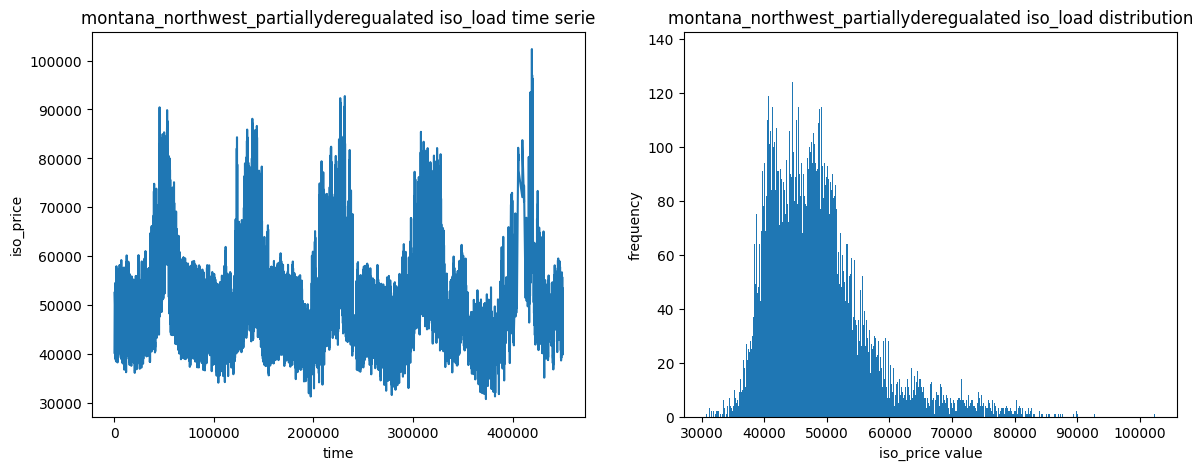

In [12]:
# Visualize to understand the non-null data pattern
iso_load_montana_northwest_partiallyderegulated_not_null = import_df[(import_df['iso_info']=='Montana') | (import_df['iso_info']=='Northwest') & import_df['iso_load'].notnull()]['iso_load']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(iso_load_montana_northwest_partiallyderegulated_not_null)
axes[0].set_title("montana_northwest_partiallyderegualated iso_load time serie")
axes[0].set_xlabel("time")
axes[0].set_ylabel("iso_price")

axes[1].hist(iso_load_montana_northwest_partiallyderegulated_not_null, bins = 2000)
axes[1].set_title("montana_northwest_partiallyderegualated iso_load distribution")
axes[1].set_xlabel("iso_price value")
axes[1].set_ylabel("frequency")

# Statistical measures
print(f'''iso_price mean: {iso_load_montana_northwest_partiallyderegulated_not_null.mean()}''')
print(f'''iso_price median: {iso_load_montana_northwest_partiallyderegulated_not_null.median()}''')

In [13]:
# Replace the null value
import_df['iso_load'] = import_df['iso_load'].fillna(iso_load_montana_northwest_partiallyderegulated_not_null.median())

C:\Users\thanh\AppData\Local\Temp\ipykernel_2044\913731943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_df['iso_load'] = import_df['iso_load'].fillna(iso_load_montana_northwest_partiallyderegulated_not_null.median())


### 2.1.3. henry_gas and aeco_gas

In [14]:
# Check the characteristic of null rows
import_df[(import_df['henry_gas'].isnull()) | (import_df['aeco_gas'].isnull())]['ym']

1      2018-01
5      2018-01
13     2018-01
21     2018-01
30     2018-01
40     2018-01
50     2018-01
60     2018-01
63     2018-01
70     2018-01
80     2018-01
90     2018-01
100    2018-01
110    2018-01
120    2018-01
130    2018-01
133    2018-01
136    2018-01
140    2018-01
146    2018-01
156    2018-01
166    2018-01
170    2018-01
172    2018-01
175    2018-01
179    2018-01
Name: ym, dtype: object

Mean of henry_gas in 2018-01: 3.826751510159253
Median of henry_gas in 2018-01: 3.542
Mean of aeco_gas in 2018-01: 1.6551089239850356
Median of aeco_gas in 2018-01: 1.625180665


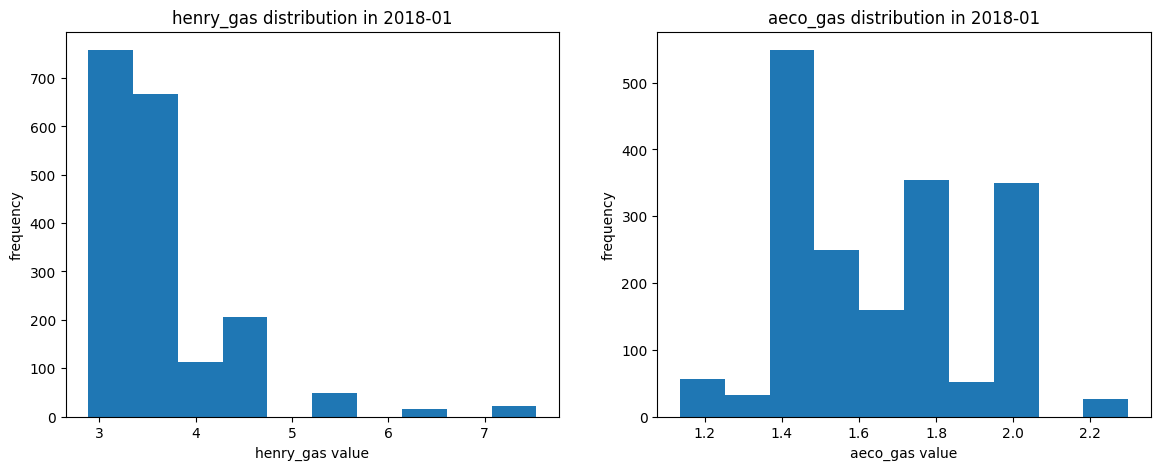

In [15]:
# Visualize to understand the non-null data pattern
henry_gas_not_null = import_df[(import_df['ym']=='2018-01') & import_df['henry_gas'].notnull()]['henry_gas']
aeco_gas_not_null = import_df[(import_df['ym']=='2018-01') & import_df['aeco_gas'].notnull()]['aeco_gas']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(henry_gas_not_null)
axes[0].set_title("henry_gas distribution in 2018-01")
axes[0].set_xlabel("henry_gas value")
axes[0].set_ylabel("frequency")

axes[1].hist(aeco_gas_not_null)
axes[1].set_title("aeco_gas distribution in 2018-01")
axes[1].set_xlabel("aeco_gas value")
axes[1].set_ylabel("frequency")

# Statistical measures
print(f'''Mean of henry_gas in 2018-01: {df[df['ym'] == '2018-01']['henry_gas'].mean()}''')
print(f'''Median of henry_gas in 2018-01: {df[df['ym'] == '2018-01']['henry_gas'].median()}''')

print(f'''Mean of aeco_gas in 2018-01: {df[df['ym'] == '2018-01']['aeco_gas'].mean()}''')
print(f'''Median of aeco_gas in 2018-01: {df[df['ym'] == '2018-01']['aeco_gas'].median()}''')

In [16]:
# Replace the null value
import_df['henry_gas'] = import_df['henry_gas'].fillna(import_df[import_df['ym'] == '2018-01']['henry_gas'].median())
import_df['aeco_gas'] = import_df['aeco_gas'].fillna(import_df[import_df['ym'] == '2018-01']['aeco_gas'].mean())

C:\Users\thanh\AppData\Local\Temp\ipykernel_2044\538889750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_df['henry_gas'] = import_df['henry_gas'].fillna(import_df[import_df['ym'] == '2018-01']['henry_gas'].median())
C:\Users\thanh\AppData\Local\Temp\ipykernel_2044\538889750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_df['aeco_gas'] = import_df['aeco_gas'].fillna(import_df[import_df['ym'] == '2018-01']['aeco_gas'].mean())


## 2.2. Create time series features

In [17]:
# Group the dataframe by 'date' and 'iso_info'
import_df_grouped = import_df.groupby(by = ['date','iso_info']).agg(mean_daily_transfers_MWh = ('transfers_MWh', 'mean')).reset_index()
import_df_grouped['date'] = pd.to_datetime(import_df_grouped['date'], dayfirst=True)
import_df_grouped = import_df_grouped.sort_values(by=['iso_info', 'date'])

# Create time series features
import_df_grouped['ma_3lag'] = import_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(3, min_periods=1).mean()
import_df_grouped['ma_7lag'] = import_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(7, min_periods=1).mean()
import_df_grouped['ma_30lag'] = import_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(30, min_periods=1).mean()
import_df_grouped['ma_60lag'] = import_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(60, min_periods=1).mean()
import_df_grouped['ma_90lag'] = import_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(90, min_periods=1).mean()

# Replace NaN value at the first row of time series features by the first mean_daily_transfers_MWh
import_df_grouped.reset_index()
import_df_grouped.iloc[0, 3:] = import_df_grouped.iloc[0, 2]

# Recheck the dataframe
import_df_grouped

,date,iso_info,mean_daily_transfers_MWh,ma_3lag,ma_7lag,ma_30lag,ma_60lag,ma_90lag
11,2018-01-05,Dakota,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
14,2018-01-06,Dakota,126.428571,75.000000,75.000000,75.000000,75.000000,75.000000
19,2018-01-07,Dakota,135.000000,100.714286,100.714286,100.714286,100.714286,100.714286
24,2018-01-08,Dakota,135.000000,112.142857,112.142857,112.142857,112.142857,112.142857
29,2018-01-09,Dakota,99.000000,132.142857,117.857143,117.857143,117.857143,117.857143
...,...,...,...,...,...,...,...,...
5673,2022-11-27,West,299.214286,243.937179,176.576252,125.765181,121.852791,124.740152
5676,2022-11-28,West,175.000000,255.258608,196.464007,132.778990,124.120945,126.763644
5680,2022-11-29,West,8.000000,228.438095,220.892578,137.012323,124.907056,127.628089
5689,2022-12-01,West,157.000000,160.738095,202.511626,136.445657,122.511818,126.036977


C:\Users\thanh\AppData\Local\Temp\ipykernel_2044\2813922648.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'transferred_MWh')

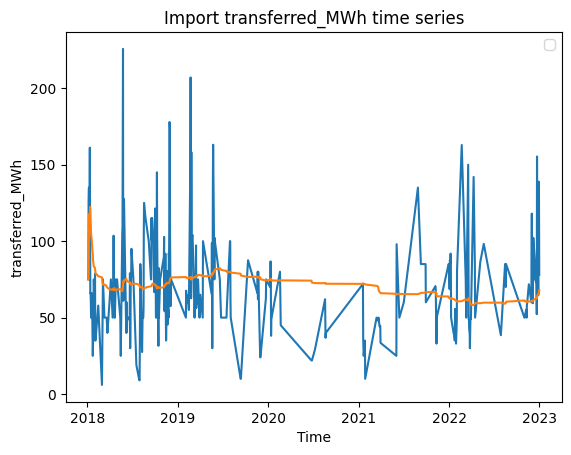

In [18]:
# Recheck the time series feature with 'Dakota' example
import_df_grouped_dakota = import_df_grouped[import_df_grouped['iso_info']=='Dakota']
plt.plot(import_df_grouped_dakota['date'], import_df_grouped_dakota['mean_daily_transfers_MWh'])
plt.plot(import_df_grouped_dakota['date'], import_df_grouped_dakota['ma_90lag'])
plt.title('Import transferred_MWh time series')
plt.legend()
plt.xlabel('Time')
plt.ylabel('transferred_MWh')

In [19]:
# Drop the 'mean_daily_transfers_MWh' column
import_df_grouped = import_df_grouped.drop(columns='mean_daily_transfers_MWh')

In [20]:
# Merge the original dataframe with new time series features
import_df_merged = pd.merge(left=import_df, right=import_df_grouped, how='inner', on=['date', 'iso_info'])

## 2.3. Distribution and correlation of numerical columns

In [21]:
# Get numerical columns
numerical_col = import_df_merged.select_dtypes(include=["int64", "float64"]).columns
numerical_col

Index(['year', 'month', 'day', 'annual_hour', 'transfers_MWh', 'price_usd',
       'price_cad', 'fx', 'iso_price', 'iso_load', 'henry_gas', 'aeco_gas',
       'bio_iso_mwh', 'coal_iso_mwh', 'storage_iso_mwh', 'geo_iso_mwh',
       'gas_iso_mwh', 'other_iso_mwh', 'oil_iso_mwh', 'solar_iso_mwh',
       'nuclear_iso_mwh', 'hydro_iso_mwh', 'wind_iso_mwh', 'total_iso_mwh',
       'bio_iso_share', 'coal_iso_share', 'storage_iso_share', 'geo_iso_share',
       'gas_iso_share', 'other_iso_share', 'oil_iso_share', 'solar_iso_share',
       'nuclear_iso_share', 'hydro_iso_share', 'wind_iso_share',
       'solar_radiation', 'wind_speed', 'ma_3lag', 'ma_7lag', 'ma_30lag',
       'ma_60lag', 'ma_90lag'],
      dtype='object')

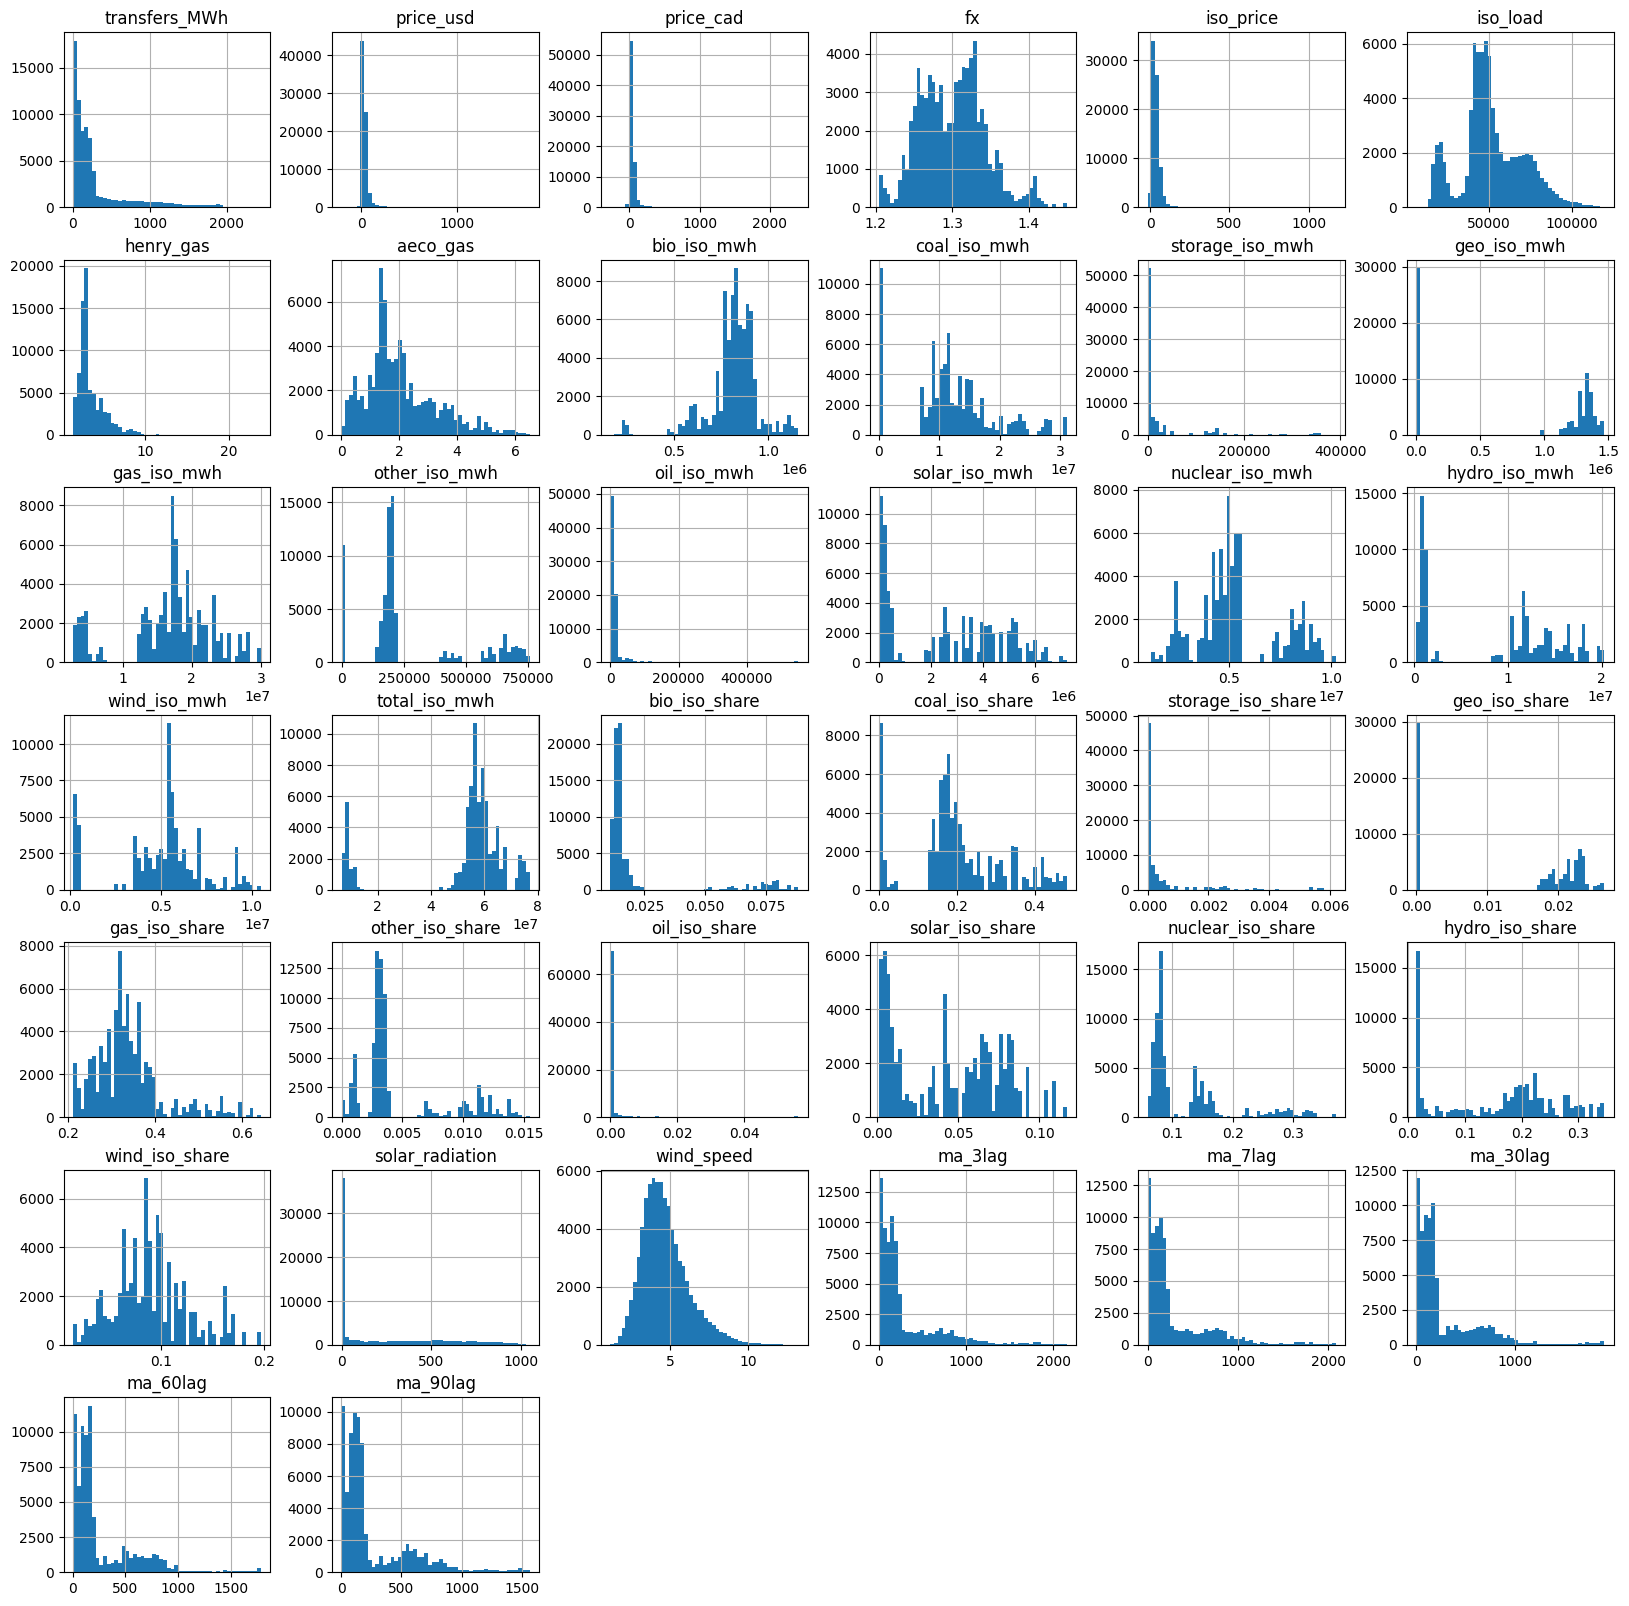

In [22]:
# Plot the distribution of numerical columns
import_df_merged[numerical_col[4:]].hist(figsize=(20, 20), bins=50)
plt.show()

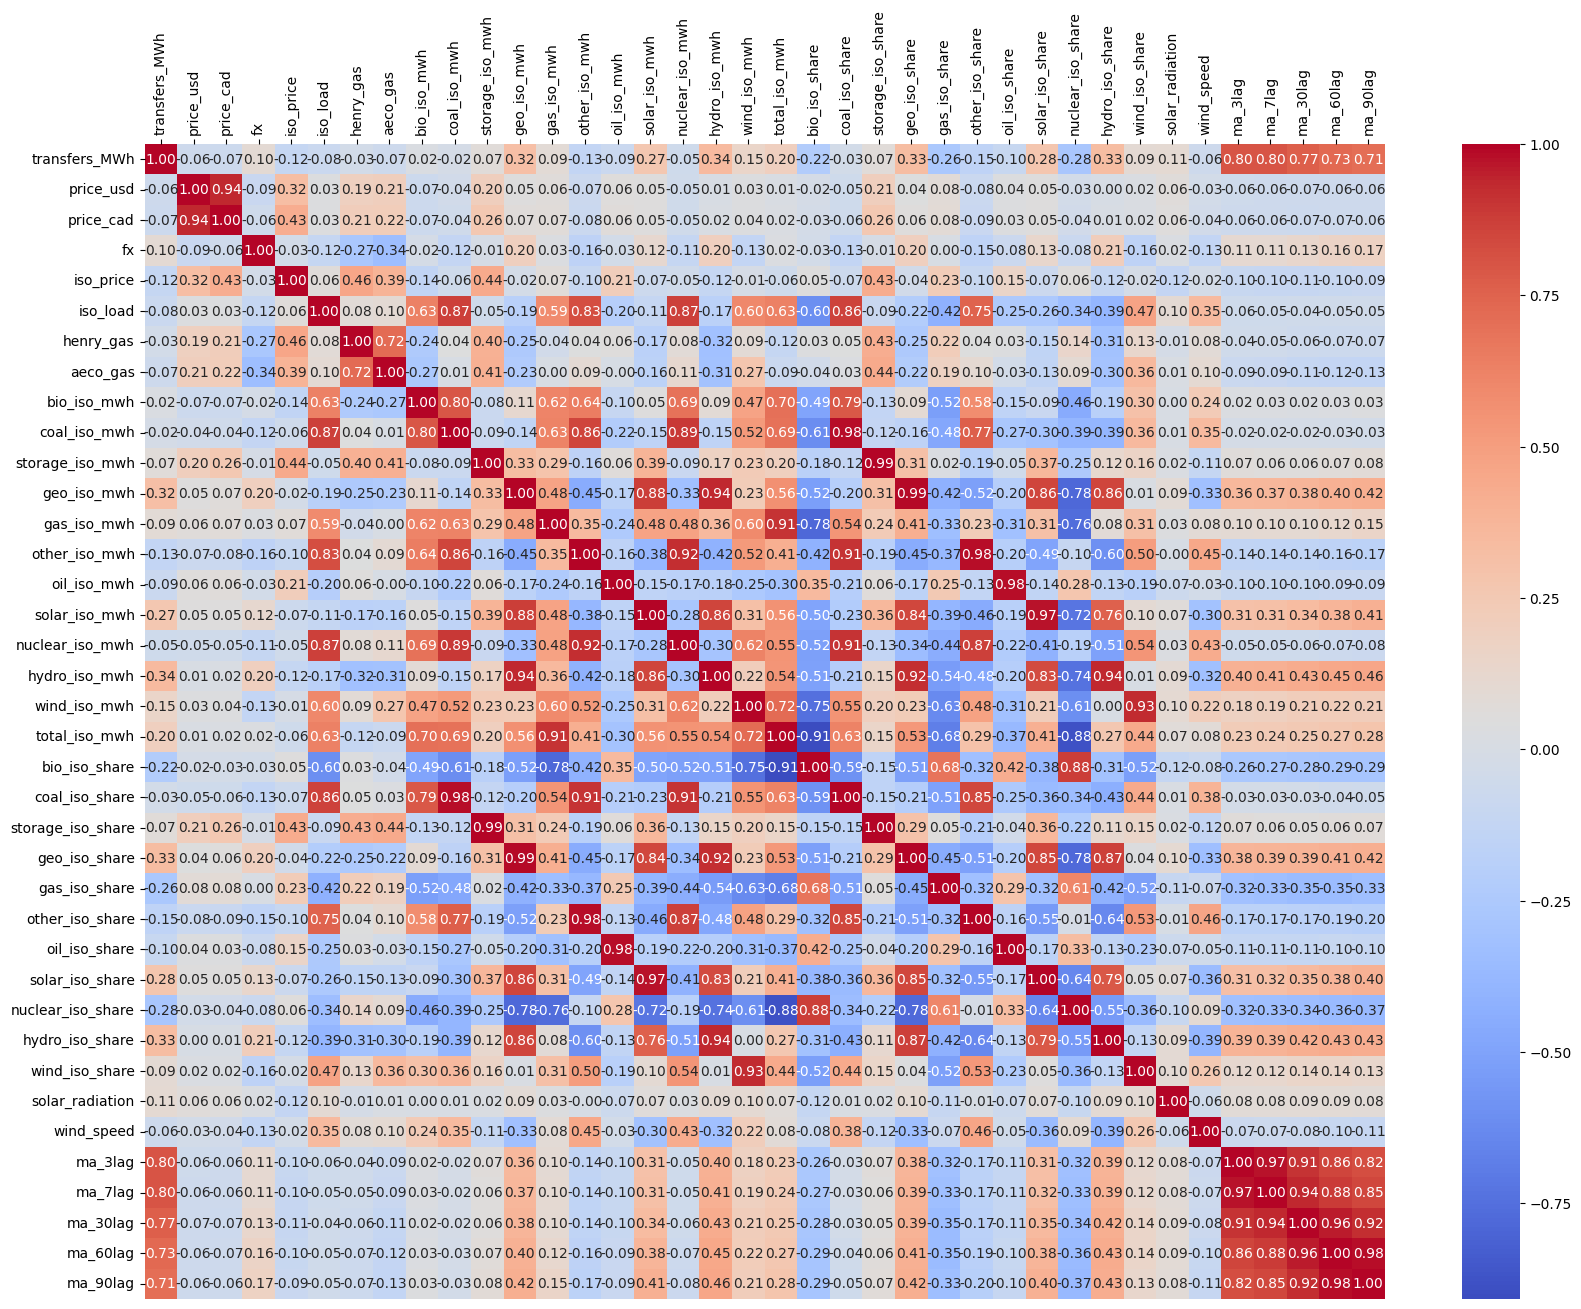

In [23]:
# Plot the correlation between variables
plt.figure(figsize=(20, 15))

ax = sns.heatmap(import_df_merged[numerical_col[4:]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

ax.xaxis.set_ticks_position("top")  
ax.xaxis.set_label_position("top")  
plt.xticks(rotation=90)

plt.show()

# 3. Set up machine learning pipeline and intial models

## 3.1. Feature engineering

In [48]:
# Features
X = import_df_merged[[
    'year', 'month', 'day', 'annual_hour', # Time
    'iso', 'province', 'iso_info', # Trade Partners and location
    'trade_type', # Trade Data
    'price_usd', 'price_cad', 'fx', 'iso_price', 'iso_regulate', # Pricing information
    'iso_load', # System information
    'henry_gas', 'aeco_gas', 'solar_radiation', 'wind_speed', # Environmental factors
    'bio_iso_mwh', 'coal_iso_mwh', 'storage_iso_mwh', 'geo_iso_mwh', 'gas_iso_mwh', 'other_iso_mwh', 'oil_iso_mwh', 'solar_iso_mwh', 
    'nuclear_iso_mwh', 'hydro_iso_mwh', 'wind_iso_mwh', 'total_iso_mwh', # Generation by source in MWh
    'bio_iso_share', 'coal_iso_share', 'storage_iso_share', 'geo_iso_share', 'gas_iso_share', 'other_iso_share', 'oil_iso_share', 'solar_iso_share', 
    'nuclear_iso_share', 'hydro_iso_share', 'wind_iso_share', # Generation share by source
    'ma_3lag', 'ma_7lag', 'ma_30lag', 'ma_60lag', 'ma_90lag' # Time series features
    ]]

# Target
y = import_df_merged[['transfers_MWh']] # Electricity transferred in MWh

# Get the list of numerical and categorical features
X_num = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
X_cat = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Set up transformers in a preprocessor with LogTransform, StandardScaler and OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, validate=True), 
         ['henry_gas', 'aeco_gas', 'bio_iso_mwh', 'coal_iso_mwh', 'oil_iso_mwh', 'storage_iso_mwh', 'geo_iso_mwh', 'storage_iso_share', 
          'oil_iso_share', 'other_iso_mwh', 'solar_iso_mwh', 'hydro_iso_mwh', 'bio_iso_share', 'gas_iso_share', 'nuclear_iso_share', 
          'ma_3lag', 'ma_7lag', 'ma_30lag', 'ma_60lag', 'ma_90lag']),
        ('num', StandardScaler(), X_num[4:]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_cat)
    ]
)

# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 3.2. Initial machine learning models

In [49]:
# Initial models with rule-of-thumb hyperparameters
initial_models = {
    "Linear Regression": LinearRegression(n_jobs=-1
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_split=5, max_features=0.8, criterion='squared_error', bootstrap=True, n_jobs=-1
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=0.8, 
        objective="reg:squarederror", tree_method='gpu_hist', gpu_id=0, subsample=0.8 
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.01, reg_alpha=0.1, reg_lambda=0.1, 
        bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8, 
        objective='regression', device='gpu', gpu_platform_id=0, gpu_device_id=0
    )
}

## 3.3. Train and evaluate initial models

In [50]:
# Define evaluation metrics function
def eval_kpis(y_pred, y_test):
    mae_percentage = mean_absolute_error(y_test, y_pred) / y_test.mean()
    rmse_percentage = math.sqrt(mean_squared_error(y_test, y_pred)) / y_test.mean()
    r_square = r2_score(y_test, y_pred)
    
    print(f'MAE%: {float(mae_percentage):.2f}')
    print(f'RMSE%: {float(rmse_percentage):.2f}')
    print(f'R²: {r_square:.2f}')

In [51]:
# Train and evaluate the intial models
for name, model in initial_models.items():
    print(f"Training {name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(f'{name} Performance:')
    eval_kpis(y_pred, y_test)
    print("-" * 40)

Training Linear Regression...
Linear Regression Performance:
MAE%: 0.46
RMSE%: 0.78
R²: 0.69
----------------------------------------
Training Random Forest...


C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Performance:
MAE%: 0.33
RMSE%: 0.60
R²: 0.82
----------------------------------------
Training XGBoost...


C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:48:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\

XGBoost Performance:
MAE%: 0.58
RMSE%: 0.90
R²: 0.59
----------------------------------------
Training LightGBM...


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11882
[LightGBM] [Info] Number of data points in the train set: 60999, number of used features: 79
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')


# 4. Tune hyperparameters and choose the best model

## 4.1. Define K-Fold Cross-Validation and hyperparameter grids for each model

In [52]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True)

# Parameter grids
param_grids = {
    "Random Forest": {
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [10, 20, 30, 40],
        'model__min_samples_split': [5, 10, 15, 20]
    },
    "XGBoost": {
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [3, 5, 7, 9],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.04]
    },
    "LightGBM": {
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [5, 10, 15, 20],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.04]
    }
}

## 4.2. Use Random Search for choosing the best model

In [53]:
# Models
models = {
    "Random Forest": RandomForestRegressor(
        criterion='squared_error', 
        bootstrap=True, 
        n_jobs=-1
    ),
    "XGBoost": xgb.XGBRegressor(
        objective="reg:squarederror", 
        subsample=0.8, 
        tree_method='gpu_hist', gpu_id=0
    ),
    "LightGBM": lgb.LGBMRegressor(objective='regression', reg_alpha=0.1, reg_lambda=0.1, 
                                  bagging_fraction=0.8, bagging_freq=5, 
                                  device='gpu', gpu_platform_id=0, gpu_device_id=0
    )
}

# Dictionary to store best model and score
best_models = {}
best_scores = {}

for name, model in models.items():
    print(f"Tuning {name} with RandomizedSearchCV and {kf.get_n_splits()}-Fold CV...")
    
    # Pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Random Search with K-Fold Cross-Validation
    random_search  = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grids[name], cv=kf, n_iter=10, 
                                        scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
    random_search.fit(X_train, y_train)
    
    # Store best model and score
    best_models[name] = random_search.best_estimator_
    best_scores[name] = -random_search.best_score_
    
    print(f"Best parameters for {name}: {random_search.best_params_}")
    print(f"Best MSE: {-random_search.best_score_:.4f}")
    print("-" * 50)

# Select the best model based on MSE
best_model_name = min(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print(f"Best overall model: {best_model_name}")

Tuning Random Forest with RandomizedSearchCV and 5-Fold CV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters for Random Forest: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__max_depth': 40}
Best MSE: 18339.7523
--------------------------------------------------
Tuning XGBoost with RandomizedSearchCV and 5-Fold CV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [02:11:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for XGBoost: {'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.04}
Best MSE: 26560.9562
--------------------------------------------------
Tuning LightGBM with RandomizedSearchCV and 5-Fold CV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11882
[LightGBM] [Info] Number of data points in the train set: 60999, number of used features: 79
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 61 dense feature groups (3.72 MB) transfer

# 5. Evaluate the best model with evaluation set

In [54]:
# The best model pipeline
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['henry_gas', 'aeco_gas',
                                                   'bio_iso_mwh',
                                                   'coal_iso_mwh',
                                                   'oil_iso_mwh',
                                                   'storage_iso_mwh',
                                                   'geo_iso_mwh',
                                                   'storage_iso_share',
                                                   'oil_iso_share',
                                                   'other_iso_mwh',
                                                   'solar_iso_mwh',
                                                   'hydro_iso_mwh',
                                                   'bio_iso_share',
                                                   'gas_iso_share',
                                                   'nuclear_...
                                                   'total_iso_mwh',
                                                   'bio_iso_share',
                                                   'coal_iso_share',
                                                   'storage_iso_share',
                                                   'geo_iso_share',
                                                   'gas_iso_share',
                                                   'other_iso_share',
                                                   'oil_iso_share',
                                                   'solar_iso_share',
                                                   'nuclear_iso_share', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iso', 'province',
                                                   'iso_info', 'trade_type',
                                                   'iso_regulate'])])),
                ('model',
                 RandomForestRegressor(max_depth=40, min_samples_split=5,
                                       n_jobs=-1))])

In [55]:
# Evaluate the best model with evaluation set
y_best_pred = best_model.predict(X_test)
eval_kpis(y_best_pred, y_test)

MAE%: 0.21
RMSE%: 0.41
R²: 0.92


C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')


# 6. Analyse feature importance

In [56]:
# The best model
best_rf_model = best_models["Random Forest"].named_steps['model']
best_rf_model

RandomForestRegressor(max_depth=40, min_samples_split=5, n_jobs=-1)

In [57]:
# Get the feature names
preprocessor = best_models["Random Forest"].named_steps['preprocessor']

feature_names = []
for name, transformer, cols in preprocessor.transformers_:
    if hasattr(transformer, "get_feature_names_out"):
        feature_names.extend(transformer.get_feature_names_out())
    else:
        # Use original column names if `get_feature_names_out()` is not available
        feature_names.extend(cols if isinstance(cols, list) else [cols])
feature_names = feature_names[:-1]
print(feature_names)

['henry_gas', 'aeco_gas', 'bio_iso_mwh', 'coal_iso_mwh', 'oil_iso_mwh', 'storage_iso_mwh', 'geo_iso_mwh', 'storage_iso_share', 'oil_iso_share', 'other_iso_mwh', 'solar_iso_mwh', 'hydro_iso_mwh', 'bio_iso_share', 'gas_iso_share', 'nuclear_iso_share', 'ma_3lag', 'ma_7lag', 'ma_30lag', 'ma_60lag', 'ma_90lag', 'price_usd', 'price_cad', 'fx', 'iso_price', 'iso_load', 'henry_gas', 'aeco_gas', 'solar_radiation', 'wind_speed', 'bio_iso_mwh', 'coal_iso_mwh', 'storage_iso_mwh', 'geo_iso_mwh', 'gas_iso_mwh', 'other_iso_mwh', 'oil_iso_mwh', 'solar_iso_mwh', 'nuclear_iso_mwh', 'hydro_iso_mwh', 'wind_iso_mwh', 'total_iso_mwh', 'bio_iso_share', 'coal_iso_share', 'storage_iso_share', 'geo_iso_share', 'gas_iso_share', 'other_iso_share', 'oil_iso_share', 'solar_iso_share', 'nuclear_iso_share', 'hydro_iso_share', 'wind_iso_share', 'ma_3lag', 'ma_7lag', 'ma_30lag', 'ma_60lag', 'ma_90lag', 'iso_ISO-NE', 'iso_MISO', 'iso_NYISO', 'iso_WECC', 'province_AB', 'province_BC', 'province_MB', 'province_NB', 'provin

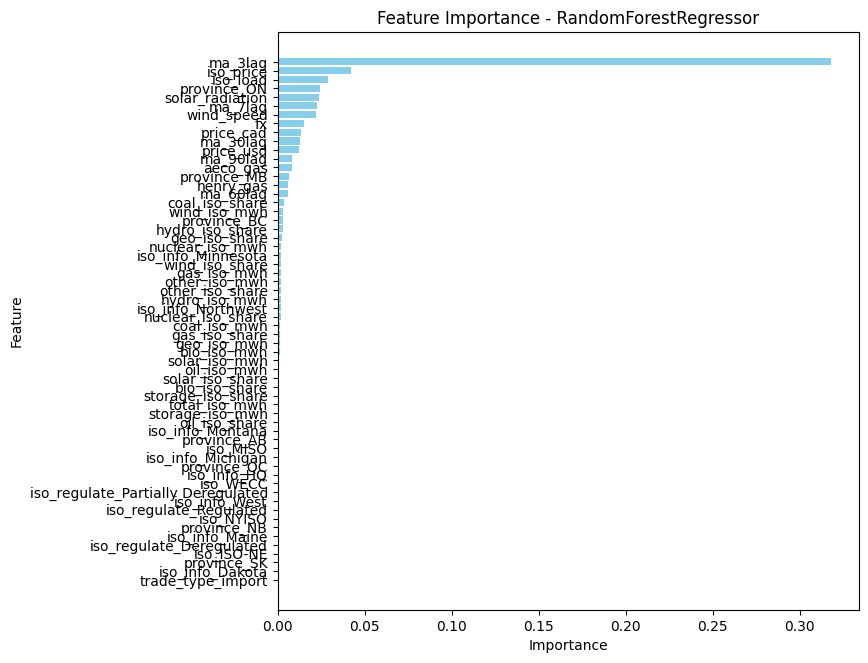

In [69]:
# Get feature importance values
feature_importance = best_rf_model.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(7.5, 7.5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - RandomForestRegressor')
plt.gca().invert_yaxis()
plt.show()

In [59]:
# Define a threshold of 95% feature importance
importance_df['Cumulative Importance'] = importance_df['Importance'].cumsum()
threshold = 0.95
selected_features = importance_df[importance_df['Cumulative Importance'] <= threshold]
print(selected_features)

            Feature  Importance  Cumulative Importance
52          ma_3lag    0.318095               0.318095
15          ma_3lag    0.312967               0.631062
23        iso_price    0.042105               0.673167
24         iso_load    0.028803               0.701969
65      province_ON    0.024273               0.726242
27  solar_radiation    0.023751               0.749992
16          ma_7lag    0.022596               0.772589
28       wind_speed    0.022213               0.794802
53          ma_7lag    0.019963               0.814765
22               fx    0.015316               0.830081
21        price_cad    0.013133               0.843214
17         ma_30lag    0.012742               0.855956
54         ma_30lag    0.012691               0.868647
20        price_usd    0.012481               0.881128
19         ma_90lag    0.008359               0.889487
26         aeco_gas    0.008009               0.897496
56         ma_90lag    0.007939               0.905435
1         

# 7. Evaluate the best model with key features

In [60]:
# Key feature
X_key = pd.get_dummies(X)[['ma_3lag', 'iso_info_Minnesota', 'province_MB', 
                           'iso_price', 'ma_7lag', 'wind_speed', 'iso_load', 'price_cad',
                           'price_usd', 'fx', 'ma_30lag', 'ma_90lag', 'solar_radiation', 'ma_60lag']]

# Split training and evaluation set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_key, y, test_size=0.2, random_state=None)

In [61]:
# Fit the best model with key features
best_model_with_key_features = RandomForestRegressor(max_depth=40, min_samples_split=5, n_estimators=300, n_jobs=-1)
best_model_with_key_features.fit(X_train_final, y_train_final)

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=40, min_samples_split=5, n_estimators=300,
                      n_jobs=-1)

In [62]:
# Evaluate the best model with key features
y_pred_final = best_model_with_key_features.predict(X_test_final)
eval_kpis(y_pred=y_pred_final, y_test=y_test_final)

MAE%: 0.22
RMSE%: 0.43
R²: 0.90


C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_22364\4029147040.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')
